# Practica 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from control import *

CB_color_cycle = (
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
)

In [2]:
def filter(num: np.ndarray, den: np.ndarray, input: np.ndarray) -> np.ndarray:
    # Convertir a arrays de tipo float para evitar problemas de división
    num = np.array(num, dtype=float)
    den = np.array(den, dtype=float)

    # Validación de la longitud de los coeficientes
    if len(den) < 1 or len(num) < 1:
        raise ValueError("Los coeficientes del numerador y del denominador deben tener al menos un elemento.")
    
    # Normalización del denominador
    if den[0] != 1:
        num = num / den[0]
        den = den / den[0]

    # Longitud de la entrada y los coeficientes
    N = len(input)
    M = len(num)
    K = len(den)

    # Salida inicializada a ceros
    output = np.zeros(N)

    # Aplicar la ecuación en diferencias
    for n in range(N):
        # Parte del numerador
        for m in range(M):
            if n - m >= 0:
                output[n] += num[m] * input[n - m]
        
        # Parte del denominador
        for k in range(1, K):
            if n - k >= 0:
                output[n] -= den[k] * output[n - k]
    
    return output

1) Crear una función que aplique la función de identificación por 
método de cuadrados mínimos (LS) y obtenga el vector de parámetros del modelo 
a partir del orden deseado del sistema y las señales de entrada/salida.

In [3]:
def identificacionLS(n, u, y):
    """
    Identifica los parámetros de un sistema de orden n usando el método de mínimos cuadrados.
    
    Parámetros:
    n (int): Orden del sistema.
    u (array_like): Señal de entrada.
    y (array_like): Señal de salida.

    Retorna:
    Theta (numpy.ndarray): Vector de parámetros identificados.
    """
    
    # Extrae el segmento de y desde el índice n hasta el final
    Y = y[n:]
    
    # Calcula el número de filas y columnas para Phi
    # Número de filas: longitud de Y
    # Número de columnas: n (valores retrasados de y) + (n + 1) (valores retrasados de u)
    num_filas = len(Y)
    num_columnas = 2 * n + 1
    
    # Inicializa la matriz Phi con ceros. Tiene tantas filas como elementos en Y,
    # y 2*n + 1 columnas
    Phi = np.zeros((num_filas, num_columnas))
       
    # Construcción de Phi
    # Rellena las primeras n columnas de Phi con valores de y retrasados
    Phi[:, :n] = np.array([y[n-1-i:len(y)-1-i] for i in range(n)]).T
    
    # Rellena las últimas n+1 columnas de Phi con valores de u retrasados
    Phi[:, n:] = np.array([u[n-j:len(y)-j] for j in range(n+1)]).T
        
    # Calcula Theta usando la fórmula de mínimos cuadrados:
    # Theta = (Phi' * Phi)^(-1) * Phi' * Y
    Theta = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ Y
    
    return Theta

2) Crear una función que aplique la función de identificación por 
método de cuadrados mínimos recursivo (RLS) y obtenga el vector de parámetros 
del modelo a partir del orden deseado del sistema y las señales de 
entrada/salida.

In [4]:
def identificacionRLS(n: int, u: np.ndarray, y: np.ndarray, lastP: np.ndarray, lastTheta: np.ndarray):
    """
    Identifica los parámetros de un sistema de orden n usando el método de mínimos cuadrados recursivo (RLS).
    
    Parámetros:
    n (int): Orden del sistema.
    u (array_like): Señal de entrada.
    y (array_like): Señal de salida.
    lastP (numpy.ndarray): Matriz P de la iteración anterior.
    lastTheta (numpy.ndarray): Vector Theta de la iteración anterior.

    Retorna:
    Theta (numpy.ndarray): Vector de parámetros identificados.
    P (numpy.ndarray): Matriz P actualizada.
    """
    
    # Construcción de Phi utilizando los valores retrasados de y y u
    Phi = np.concatenate((y[n-1::-1], u[n::-1]))
    
    # Actualización de P usando la fórmula RLS
    Phi = Phi.reshape(-1, 1)  # Convierte Phi en un vector columna
    P = lastP - (lastP @ Phi @ Phi.T @ lastP) / (1 + Phi.T @ lastP @ Phi)
    
    # Cálculo del vector de ganancia K
    K = (lastP @ Phi) / (1 + Phi.T @ lastP @ Phi)
    # Actualización de Theta
    Theta = lastTheta + K * (y[n] - Phi.T @ lastTheta)
    

    
    return Theta, P



3) Discretizar la planta con un período de muestreo \( h = 0.1 \) s.


In [5]:
h = 0.1

num = [1, 1]
den = [1, 0.5, 1]

Hs = tf(num, den)

Hz = c2d(Hs, h, 'zoh')
print(Hz)



  0.1023 z - 0.09255
----------------------
z^2 - 1.941 z + 0.9512

dt = 0.1



4) Identificar los parámetros de la planta para orden 2 y 3 utilizando la función LS creada anteriormente.

In [6]:
t = np.arange(0, 40+h, h)

numz, denz = tfdata(Hz)
numz = numz[0][0]
denz = denz[0][0]
u = (np.random.rand(len(t), 1) > 0.5).astype(int)
y = filter(numz, denz, u)

orden_max = 3 # cambiar este valor para probar con mas ordenes

for orden in range(1, orden_max + 1):
    #defino el nombre de las variables segun el orden
    nombre_Theta_LS = f"Theta_LS_{orden}"
    nombre_numz = f"numz_LS_{orden}"
    nombre_denz = f"denz_LS_{orden}"
 
    
    Theta_LS = identificacionLS(orden, u, y)
    num_indices = list(range(orden, 2 * orden + 1))
    den_indices = list(range(0, orden))
    print(Theta_LS)
    num_coeff = [Theta_LS[indice] for indice in num_indices]
    den_coeff = [1] + [-Theta_LS[indice] for indice in den_indices]
    
    # Asigna los coeficientes a las variables con los nombres construidos dinámicamente
    locals()[nombre_Theta_LS] = [Theta_LS]
    locals()[nombre_numz] = num_coeff
    locals()[nombre_denz] = den_coeff

[9.26436240e-01 9.18906935e-02 5.30578927e-04]
[ 1.94148343e+00 -9.51229425e-01  1.02292285e-01 -9.25462957e-02
 -4.51028104e-17]
[ 1.45013572e+00  1.31056286e-01 -4.51470796e-01  1.02831904e-01
 -4.54608512e-02 -4.14918950e-02 -1.50920942e-16]


5) Obtener el error de ambas identificaciones utilizando la función de costo J.

In [7]:
# Genera las señales filtradas
for orden in range(1, orden_max + 1):
    nombre_numz = f"numz_LS_{orden}"
    nombre_denz = f"denz_LS_{orden}"
    
    # Filtrar la señal
    y_LS = filter(locals()[nombre_numz], locals()[nombre_denz], u)
    
    # Calcular el error
    error = y - y_LS
    
    # Calcular el costo
    J = np.dot(error.T, error) / 2
    
    # Imprimir el costo
    print(f"J_{orden}:", J)


J_1: 9.759549706774724
J_2: 3.351584053240775e-22
J_3: 2.3169993642945078e+82


6) Comparar la respuesta de los modelos obtenidos en el punto 4 con la 
respuesta de la planta real utilizando la misma señal de entrada.

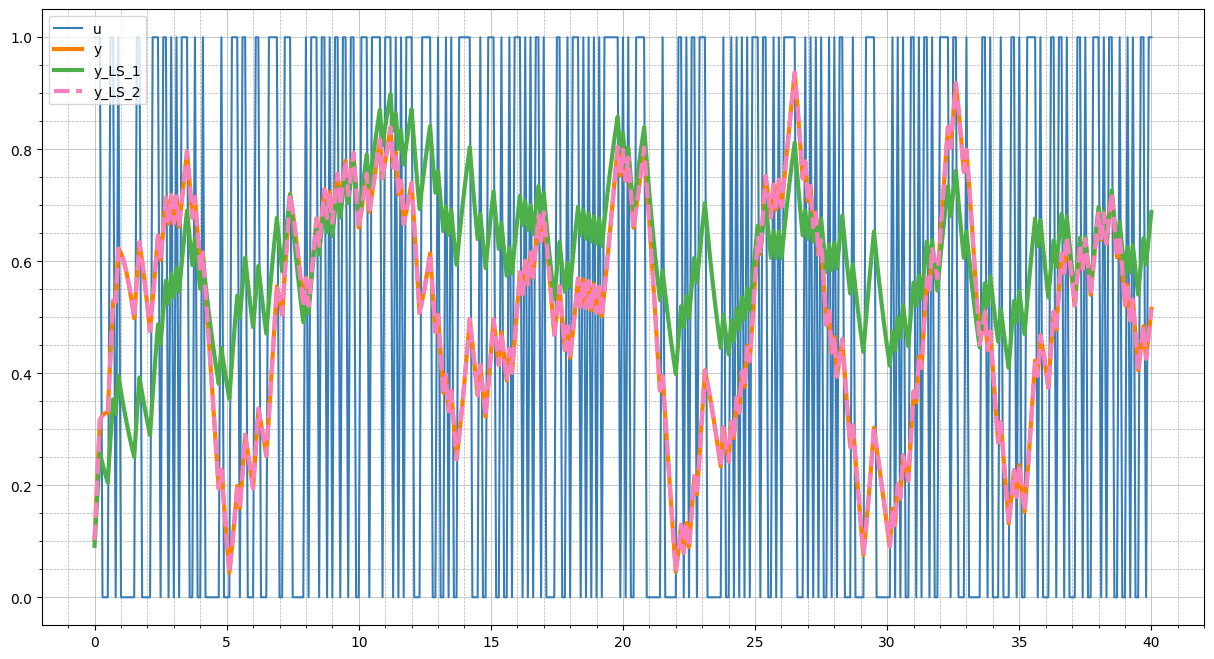

In [8]:
u = (np.random.rand(len(t), 1) > 0.5).astype(int)

# Filtrar las señales
y = filter(numz, denz, u)
y_LS_1 = filter(numz_LS_1, denz_LS_1, u)
y_LS_2 = filter(numz_LS_2, denz_LS_2, u)

# Graficar las señales
plt.figure(figsize=(15, 8))
plt.plot(t, u, label='u', color=CB_color_cycle[0])
plt.plot(t, y, linewidth=3, label='y', color=CB_color_cycle[1])
plt.plot(t, y_LS_1, linewidth=3, label='y_LS_1', color=CB_color_cycle[2])
plt.plot(t, y_LS_2, '--', linewidth=3, label='y_LS_2', color=CB_color_cycle[3])
plt.grid(which='major', linestyle='-', linewidth=0.5)
plt.grid(which='minor', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.legend()
plt.show()

7) Identificar los parámetros de la planta utilizando la función RLS creada anteriormente. Obtener y comparar identificaciones con $P_{inicial} = 100 \cdot I$ y $P_{inicial} = 1000 \cdot I$.


In [9]:
N = 300

Theta_RLS_1 = np.zeros((5, 1))
P = np.eye(5) * 100

t = np.arange(0, N)

u = (np.random.rand(len(t), 1) > 0.5).astype(int).flatten()
y = filter(numz, denz, u)

# Suponiendo que u y y están definidos previamente

for i in range(2, N):
    Theta_RLS_1, P = identificacionRLS(2, u[i-2:i+1], y[i-2:i+1], P, Theta_RLS_1)
    
numz_RLS_1 = [Theta_RLS_1[2].item(), Theta_RLS_1[3].item(), Theta_RLS_1[4].item()]
denz_RLS_1 = [1, -Theta_RLS_1[0].item(), -Theta_RLS_1[1].item()]

Theta_RLS_2 = np.zeros((5, 1))
P = np.eye(5) * 1000

for i in range(2, N):
    Theta_RLS_2, P = identificacionRLS(2, u[i-2:i+1], y[i-2:i+1], P, Theta_RLS_2)

numz_RLS_2 = [Theta_RLS_2[2].item(), Theta_RLS_2[3].item(), Theta_RLS_2[4].item()]
denz_RLS_2 = [1, -Theta_RLS_2[0].item(), -Theta_RLS_2[1].item()]



8) Comparar la respuesta de los modelos obtenidos en el punto anterior con la respuesta de la planta real utilizando la misma señal de entrada.


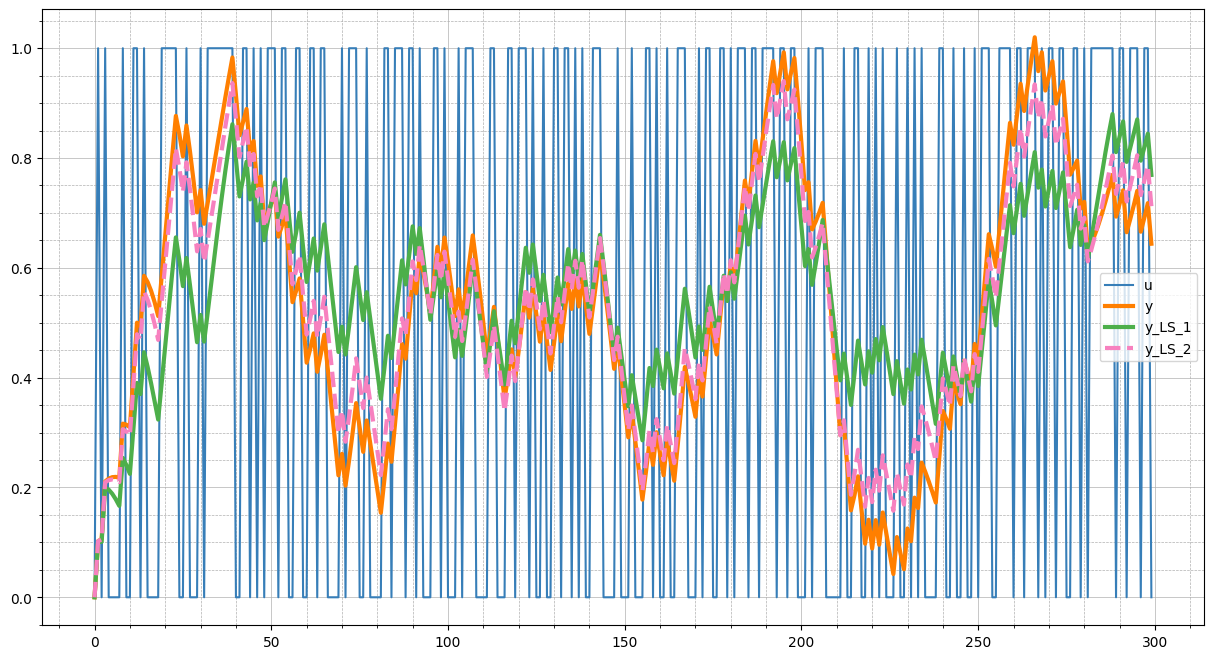

In [10]:
y_RLS_1 = filter(numz_RLS_1, denz_RLS_1, u)
y_RLS_2 = filter(numz_RLS_2, denz_RLS_2, u)

# Graficar las señales
plt.figure(figsize=(15, 8))
plt.plot(t, u, label='u', color=CB_color_cycle[0])
plt.plot(t, y, linewidth=3, label='y', color=CB_color_cycle[1])
plt.plot(t, y_RLS_1, linewidth=3, label='y_LS_1', color=CB_color_cycle[2])
plt.plot(t, y_RLS_2, '--', linewidth=3, label='y_LS_2', color=CB_color_cycle[3])
plt.grid(which='major', linestyle='-', linewidth=0.5)
plt.grid(which='minor', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.legend()
plt.show()